# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

## 0. Importing libraries

In [49]:
colab = False

if colab:
    !pip install fitter
    !pip install pydot
    !pip install graphviz
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

from scipy import stats


In [50]:
from importlib import reload  
from utils import util
import warnings

warnings.filterwarnings("ignore")
util = reload(util)

In [51]:
# Set random seed for reproducibility
seed = 84 
util.fix_random_seed(seed)

## 1. Load and inspect the dataset

### 1.1. Load data

In [52]:
test_df, df_indexes_test = util.load_data(colab)
print(test_df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [53]:
display(test_df)

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274542,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.918877,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274543,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.950230,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274544,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.602938,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274545,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.877878,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513


In [54]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', 'loc', 'scale', '99perc', '95perc', '80perc']
test_df = test_df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = test_df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


### 1.2 Preprocess and split the dataset

In [55]:
# Standardize the dataset
df_std = util.standardize(test_df, 'beta')

In [56]:
# Split the dataset into train, validation and test
train_df_std, val_df_std, test_df_std = util.train_val_test_split(df_std, df_indexes_test)

All the data is standardized using StandardScaler, while the AMS is standardized using a specific method that involves subtracting a tolerance value to prevent it from becoming equal to 0, and then multiplying it by a scale factor to ensure that it extends the range of the AMS factor.

In [57]:
min_AMS = train_df_std['AMS'].min()
max_AMS = train_df_std['AMS'].max()

train_df_std = util.scale_AMS(train_df_std, min_AMS, max_AMS) 
val_df_std = util.scale_AMS(val_df_std, min_AMS, max_AMS) 
test_df_std = util.scale_AMS(test_df_std, min_AMS, max_AMS) 

In [58]:
# column id must be integer
train_df_std['ID'] = train_df_std['ID'].astype(int)
val_df_std['ID'] = val_df_std['ID'].astype(int)
test_df_std['ID'] = test_df_std['ID'].astype(int)

# column duration must be integer
train_df_std['duration[h]'] = train_df_std['duration[h]'].astype(int)
val_df_std['duration[h]'] = val_df_std['duration[h]'].astype(int)
test_df_std['duration[h]'] = test_df_std['duration[h]'].astype(int)

In [59]:
train_df_std.head()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001,0.162028,28.25,1,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
1,5001,0.103407,28.25,1,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
2,5001,0.146866,51.50,3,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
3,5001,0.118569,51.50,3,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
4,5001,0.157156,51.50,3,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952


In [60]:
train_df_std.describe()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
count,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,...,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000
mean,11047.209328,0.132718,57.047139,9.196126,0.024646,0.032570,0.042734,0.047496,0.014040,0.013421,...,-0.102764,0.028934,-0.070270,-0.067010,0.023610,0.001521,0.037728,0.004899,-0.072880,-0.075678
std,4333.130131,0.049723,31.055424,8.279490,0.984392,0.986320,0.981766,0.976423,1.004977,1.008808,...,0.986101,1.052469,1.018725,1.018695,0.996458,1.002549,0.995037,1.018041,0.989454,1.016837
min,5001.000000,0.001325,5.200000,1.000000,-1.020500,-1.181048,-1.331852,-1.503806,-4.369229,-3.522613,...,-1.470102,-1.519984,-1.779005,-1.935638,-1.583809,-0.479600,-1.528887,-0.637763,-2.037322,-1.886456
25%,8094.000000,0.099157,34.977778,3.000000,-0.708747,-0.817296,-0.887690,-0.666054,-0.578875,-0.620972,...,-0.984027,-0.582172,-0.864855,-0.799420,-0.757122,-0.452740,-0.764904,-0.515773,-0.969827,-0.868411
50%,12005.000000,0.123613,49.674286,6.000000,-0.264208,-0.091967,0.073687,0.116867,0.016296,0.066203,...,-0.148547,-0.118672,-0.208966,-0.251402,-0.210103,-0.420647,-0.187105,-0.435802,0.079379,-0.371707
75%,16065.000000,0.155474,70.343750,12.000000,0.480086,0.640557,0.730073,0.713190,0.644833,0.693127,...,0.563731,0.423661,0.582830,0.456927,0.596341,-0.225321,0.667556,-0.095920,0.699596,0.724815
max,20034.000000,0.833372,318.742857,24.000000,5.244876,3.734721,2.928541,3.520526,3.648847,2.935948,...,2.408305,5.536860,3.648605,3.272980,4.323812,7.312002,3.537003,6.218626,2.054450,2.471653


### 1.3 Add the guesses to datasets

Addition of estimated values of alpha e beta to be used as ground truth.

In [61]:
def add_alpha_beta(df):
 
    # create two empy columns for alpha and beta
    df['alpha'] = np.nan
    df['beta'] = np.nan
 
    for id in df['ID'].unique():
       
        for duration in DURATION:
            condition = (df['ID'] == id) & (df['duration[h]'] == duration)
            ams = df[condition]['AMS']
            
            if len(ams) < 2:
                a, b = np.nan, np.nan
            else:
                a, b, _, _ = stats.beta.fit(ams, floc=0, fscale=1)   
                        
            df.loc[condition, 'alpha'] = a
            df.loc[condition, 'beta'] = b
 
    df.dropna(inplace=True)
 
    return df

In [62]:
#train_df_std = add_alpha_beta(train_df_std)
#val_df_std = add_alpha_beta(val_df_std)
test_df_std = add_alpha_beta(test_df_std)

In [63]:
test_df_std

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,alpha,beta
0,5005,0.212248,24.120313,1,-0.953135,-1.161219,-1.317728,-1.484804,-1.151235,0.700014,...,0.706214,0.217943,-1.015168,-0.419278,-1.10543,-0.417212,0.749152,-0.274367,6.145536,40.062161
1,5005,0.283651,24.120313,1,-0.953135,-1.161219,-1.317728,-1.484804,-1.151235,0.700014,...,0.706214,0.217943,-1.015168,-0.419278,-1.10543,-0.417212,0.749152,-0.274367,6.145536,40.062161
2,5005,0.108988,24.120313,1,-0.953135,-1.161219,-1.317728,-1.484804,-1.151235,0.700014,...,0.706214,0.217943,-1.015168,-0.419278,-1.10543,-0.417212,0.749152,-0.274367,6.145536,40.062161
3,5005,0.147436,24.120313,1,-0.953135,-1.161219,-1.317728,-1.484804,-1.151235,0.700014,...,0.706214,0.217943,-1.015168,-0.419278,-1.10543,-0.417212,0.749152,-0.274367,6.145536,40.062161
4,5005,0.112832,24.120313,1,-0.953135,-1.161219,-1.317728,-1.484804,-1.151235,0.700014,...,0.706214,0.217943,-1.015168,-0.419278,-1.10543,-0.417212,0.749152,-0.274367,6.145536,40.062161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15410,17036,0.135374,57.840000,24,0.460308,1.107498,1.316827,0.935863,-0.283402,-0.423493,...,0.253606,0.381356,-0.547556,-0.307580,-0.70638,-0.353558,0.779331,1.730907,53.956378,352.557508
15411,17036,0.164693,57.840000,24,0.460308,1.107498,1.316827,0.935863,-0.283402,-0.423493,...,0.253606,0.381356,-0.547556,-0.307580,-0.70638,-0.353558,0.779331,1.730907,53.956378,352.557508
15412,17036,0.114302,57.840000,24,0.460308,1.107498,1.316827,0.935863,-0.283402,-0.423493,...,0.253606,0.381356,-0.547556,-0.307580,-0.70638,-0.353558,0.779331,1.730907,53.956378,352.557508
15413,17036,0.125754,57.840000,24,0.460308,1.107498,1.316827,0.935863,-0.283402,-0.423493,...,0.253606,0.381356,-0.547556,-0.307580,-0.70638,-0.353558,0.779331,1.730907,53.956378,352.557508


In [64]:
test_df_std.describe()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,alpha,beta
count,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,...,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000,15415.000000
mean,9832.383912,0.132717,55.861334,9.195070,-0.088081,-0.049882,-0.019438,-0.025255,-0.017539,-0.037600,...,-0.143001,-0.149457,-0.071045,-0.111435,-0.092204,-0.085457,0.048150,-0.232784,8.448894,55.129009
std,4010.761183,0.051402,29.009669,8.277529,0.871463,0.853764,0.901949,0.849007,1.061097,1.018463,...,0.775668,0.798160,0.834138,0.869970,0.802020,0.863578,0.952379,0.854566,18.139598,118.550077
min,5005.000000,0.010138,11.760000,1.000000,-1.016188,-1.176845,-1.327950,-1.498306,-2.716088,-2.891128,...,-1.773930,-1.929316,-1.292824,-0.479438,-1.458672,-0.634905,-2.024442,-1.577171,1.514727,9.565156
25%,5297.000000,0.098271,35.673418,3.000000,-0.690319,-0.716149,-0.704401,-0.544517,-0.738214,-0.878397,...,-0.775337,-0.778631,-0.731837,-0.444082,-0.699647,-0.499707,-0.587577,-0.832396,5.482549,35.710299
50%,9086.000000,0.123241,49.543636,6.000000,-0.350550,-0.189427,-0.016951,0.085177,-0.039440,0.157833,...,-0.144599,-0.134897,-0.225564,-0.418055,-0.285904,-0.419837,0.115927,-0.476058,7.092887,46.264897
75%,12281.000000,0.155436,69.003125,12.000000,0.230839,0.405562,0.605976,0.488076,0.533583,0.751791,...,0.601957,0.382422,0.319219,-0.275348,0.463252,-0.134815,0.748906,0.101654,9.727871,63.566590
max,17036.000000,0.592703,268.940000,24.000000,3.872997,3.768969,2.677571,1.872668,2.534594,1.659026,...,2.185374,2.798201,3.630957,5.033453,3.467308,5.182139,1.944183,2.009958,702.470037,4590.528841


### 1.4 Alpha and beta inspection

In [65]:
#util.geographic_plot(train_df_std, 'alpha', 'beta')

In [66]:
#histogram of AMS when alpha > 90 and beta > 500

'''
condition = (train_df_std['alpha'] > 90) & (train_df_std['beta'] > 500)
ams = train_df_std[condition]['AMS']
print(len(ams))
print(ams.values)
a, b, _, _ = stats.beta.fit(ams, floc=0, fscale=1)
print(a, b)
m, d = stats.norm.fit(ams)
print(m, d)

x = np.linspace(0, 1, 100)
dist_norm = stats.norm.pdf(x, m, d)
dist_beta = stats.beta.pdf(x, a, b)

plt.plot(x, dist_norm, 'r-', lw=1, alpha=0.6, label='norm pdf')
plt.plot(x, dist_beta, 'b-', lw=1, alpha=0.6, label='beta pdf')
plt.legend()
plt.show()
'''

"\ncondition = (train_df_std['alpha'] > 90) & (train_df_std['beta'] > 500)\nams = train_df_std[condition]['AMS']\nprint(len(ams))\nprint(ams.values)\na, b, _, _ = stats.beta.fit(ams, floc=0, fscale=1)\nprint(a, b)\nm, d = stats.norm.fit(ams)\nprint(m, d)\n\nx = np.linspace(0, 1, 100)\ndist_norm = stats.norm.pdf(x, m, d)\ndist_beta = stats.beta.pdf(x, a, b)\n\nplt.plot(x, dist_norm, 'r-', lw=1, alpha=0.6, label='norm pdf')\nplt.plot(x, dist_beta, 'b-', lw=1, alpha=0.6, label='beta pdf')\nplt.legend()\nplt.show()\n"

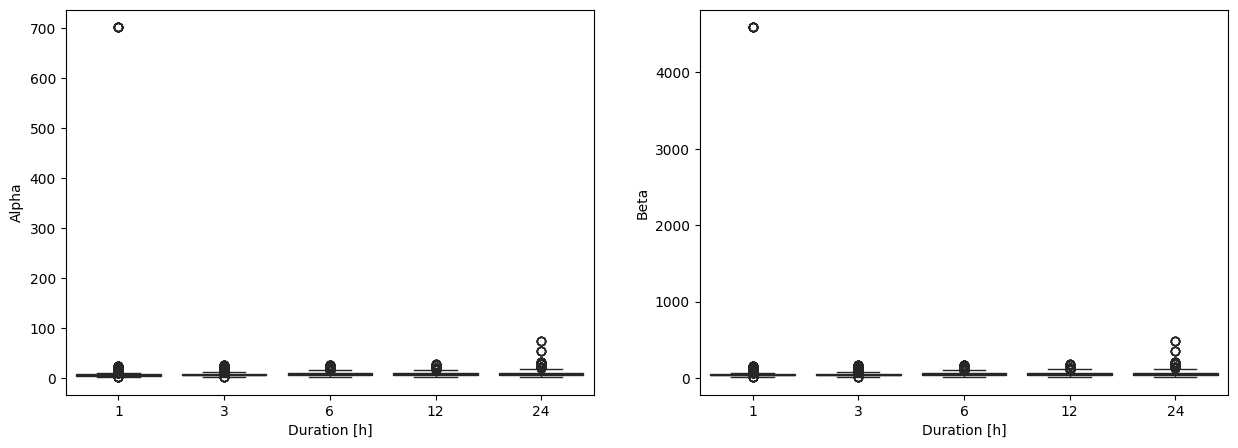

In [67]:
#boxplot of alpha and beta
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
#sns.set(rc={'axes.facecolor': '#071C42', 'figure.facecolor': '#071C42', 'text.color':'white'})

#ALPHA
sns.boxplot(x='duration[h]', y='alpha', data=test_df_std, ax=ax[0], palette='BuGn_r')

# Set both x and y axis color to white
ax[0].tick_params(axis='x')
ax[0].tick_params(axis='y')

# Set axes titles color to white
ax[0].set_xlabel("Duration [h]")
ax[0].set_ylabel("Alpha")

#BETA
sns.boxplot(x='duration[h]', y='beta', data=test_df_std, ax=ax[1], palette='BuGn_r')

ax[1].tick_params(axis='x')
ax[1].tick_params(axis='y')

# Set axes titles color to white
ax[1].set_xlabel("Duration [h]")
ax[1].set_ylabel("Beta")

plt.show()

In [68]:
sns.reset_defaults()

In [69]:
#take the ID with the highest alpha and beta for each duration
'''
def get_highest_alpha_beta(df, duration):
    highest_alpha = df[df['duration[h]']==duration]['alpha'].max()
    highest_beta = df[df['duration[h]']==duration]['beta'].max()
    return highest_alpha, highest_beta

for duration in DURATION:
    highest_alpha, highest_beta = get_highest_alpha_beta(train_df_std, duration)
    highest_alpha_ID = train_df_std.loc[train_df_std['alpha'] == highest_alpha, 'ID'].values[0] # [0] because the array contains the same value repeated
    highest_beta_ID = train_df_std.loc[train_df_std['beta'] == highest_beta, 'ID'].values[0]
    
    print('Duration: ', duration)
    print('Highest alpha: ', highest_alpha)
    print('Highest alpha ID: ', highest_alpha_ID)
    print('Highest beta: ', highest_beta)
    print('Highest beta ID: ', highest_beta_ID)
    ams = train_df_std[(train_df_std['ID']==highest_beta_ID)&(train_df_std['duration[h]']==duration)]['AMS']
    print('\t AMS:', ams.values)
    print('\n')
    
'''

"\ndef get_highest_alpha_beta(df, duration):\n    highest_alpha = df[df['duration[h]']==duration]['alpha'].max()\n    highest_beta = df[df['duration[h]']==duration]['beta'].max()\n    return highest_alpha, highest_beta\n\nfor duration in DURATION:\n    highest_alpha, highest_beta = get_highest_alpha_beta(train_df_std, duration)\n    highest_alpha_ID = train_df_std.loc[train_df_std['alpha'] == highest_alpha, 'ID'].values[0] # [0] because the array contains the same value repeated\n    highest_beta_ID = train_df_std.loc[train_df_std['beta'] == highest_beta, 'ID'].values[0]\n    \n    print('Duration: ', duration)\n    print('Highest alpha: ', highest_alpha)\n    print('Highest alpha ID: ', highest_alpha_ID)\n    print('Highest beta: ', highest_beta)\n    print('Highest beta ID: ', highest_beta_ID)\n    ams = train_df_std[(train_df_std['ID']==highest_beta_ID)&(train_df_std['duration[h]']==duration)]['AMS']\n    print('\t AMS:', ams.values)\n    print('\n')\n    \n"

In [70]:
# Create a dataframe with the count of AMS values for each ID and duration
AMS_count = test_df_std.groupby(['ID','duration[h]'])['AMS'].count()
AMS_count = pd.DataFrame(AMS_count)
AMS_count.columns = ['count']
AMS_count['alpha'] = test_df_std.groupby(['ID','duration[h]'])['alpha'].mean() 
AMS_count['beta'] = test_df_std.groupby(['ID','duration[h]'])['beta'].mean()

AMS_count.head(15)

count      alpha       beta
ID   duration[h]                             
5005 1               64   6.145536  40.062161
     3               64   6.466980  42.186205
     6               64   6.738325  43.946197
     12              64   7.092887  46.264897
     24              64   7.923504  51.697552
5007 1               20   7.119955  46.512535
     3               20   4.402060  28.668656
     6               20   5.470836  35.654375
     12              20   9.338171  60.998311
     24              20  14.662428  95.854321
5015 1               76   9.763162  63.785579
     3               76  13.345923  87.165035
     6               77  13.060766  85.274155
     12              78  12.735943  83.167007
     24              77  10.891209  71.105370

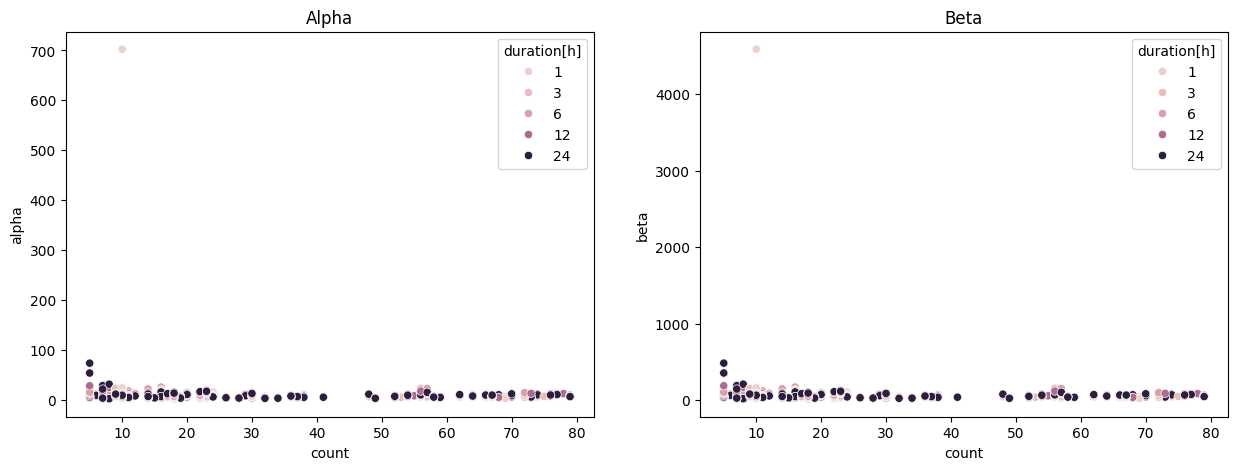

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='count', y='alpha', data=AMS_count, ax=ax[0], hue='duration[h]')
ax[0].set_title('Alpha')

sns.scatterplot(x='count', y='beta', data=AMS_count, ax=ax[1], hue='duration[h]')
ax[1].set_title('Beta')

plt.show()

### 1.5 Prepare data for training

In [72]:
# sort the dataframes by ID and then by duration
train_df_std = train_df_std.sort_values(by=['ID', 'duration[h]'])
val_df_std = val_df_std.sort_values(by=['ID', 'duration[h]'])
test_df_std = test_df_std.sort_values(by=['ID', 'duration[h]'])

# create a dict to store the indexes of same durations
durations_indexes_train = {}
for duration in DURATION:
    durations_indexes_train[duration] = train_df_std[train_df_std['duration[h]'] == duration].index

durations_indexes_val = {}
for duration in DURATION:
    durations_indexes_val[duration] = val_df_std[val_df_std['duration[h]'] == duration].index

durations_indexes_test = {}
for duration in DURATION:
    durations_indexes_test[duration] = test_df_std[test_df_std['duration[h]'] == duration].index

In [73]:
train_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'duration[h]', 'HMerit_mean(m)',
       'HMerit_stdev(m)', 'Slope_mean(deg)', 'Slope_stdev(deg)',
       'Aspect_mean(deg)', 'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)',
       'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)',
       'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)', 'OrograTirr_stdev(m)',
       'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)',
       'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')

In [74]:
test_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'duration[h]', 'HMerit_mean(m)',
       'HMerit_stdev(m)', 'Slope_mean(deg)', 'Slope_stdev(deg)',
       'Aspect_mean(deg)', 'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)',
       'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)',
       'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)', 'OrograTirr_stdev(m)',
       'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)',
       'VarClimSowP(mm)', 'X', 'Y', 'alpha', 'beta'],
      dtype='object')

In [75]:
# create a dictionary to store for each duration and for each ID the AMS values
# this will be used to make the ks-test 
AMS_dict_test = {}
for duration in DURATION:
    AMS_dict_test[duration] = test_df_std[test_df_std['duration[h]'] == duration].groupby('ID')['AMS'].apply(list).to_dict()

In [76]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
input_columns_train = train_df_std.columns[3:] 
input_columns_test = ['ID'] +list(test_df_std.columns[3:-2]) #use also ID to retrieve alpha and beta
output_column = 'AMS'
parameters_columns = ['ID','duration[h]','alpha', 'beta']
print('Input columns: ', input_columns_train)

Input columns:  Index(['duration[h]', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [77]:
inputs_train = train_df_std[input_columns_train]
outputs_train = train_df_std[output_column]
#parameters_train = train_df_std[parameters_columns]

inputs_val = val_df_std[input_columns_train]
outputs_val = val_df_std[output_column]
#parameters_val = val_df_std[parameters_columns]

inputs_test = test_df_std[input_columns_test]
outputs_test = test_df_std[output_column]
parameters_test = test_df_std[parameters_columns]

In [78]:
#make ohe for duration

inputs_train = pd.get_dummies(inputs_train, columns=['duration[h]'])
inputs_val = pd.get_dummies(inputs_val, columns=['duration[h]'])
inputs_test = pd.get_dummies(inputs_test, columns=['duration[h]'])

for duration in DURATION:
    inputs_train['duration[h]_'+str(duration)] = inputs_train['duration[h]_'+str(duration)].astype(int)
    inputs_val['duration[h]_'+str(duration)] = inputs_val['duration[h]_'+str(duration)].astype(int)
    inputs_test['duration[h]_'+str(duration)] = inputs_test['duration[h]_'+str(duration)].astype(int)

inputs_train

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),...,MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,1,0,0,0,0
1,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,1,0,0,0,0
2,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
3,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
4,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233213,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,1,0,0
233214,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,1,0,0
233215,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,1,0,0
233216,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,1,0,0


In [79]:
# Inputs to train a model with only MAP and duration

inputs_train_map = inputs_train[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_val_map = inputs_val[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_test_map = inputs_test[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]

inputs_train_map

,MAP(mm),duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,2.185839,1,0,0,0,0
1,2.185839,1,0,0,0,0
2,2.185839,0,1,0,0,0
3,2.185839,0,1,0,0,0
4,2.185839,0,1,0,0,0
...,...,...,...,...,...,...
233213,-0.125310,0,0,1,0,0
233214,-0.125310,0,0,1,0,0
233215,-0.125310,0,0,1,0,0
233216,-0.125310,0,0,1,0,0


In [80]:
# Inputs to train a model after applying PCA

inputs_train_pca = util.make_pca(inputs_train, 5)
inputs_val_pca = util.make_pca(inputs_val, 5)
inputs_test_pca = util.make_pca(inputs_test[inputs_test.columns[1:]], 5)

inputs_train_pca

,0,1,2,3,4
0,4.122811,-0.393489,-0.708271,5.286254,0.040014
1,4.122811,-0.393489,-0.708271,5.286254,0.040014
2,4.122848,-0.393510,-0.708254,5.286419,0.040041
3,4.122848,-0.393510,-0.708254,5.286419,0.040041
4,4.122848,-0.393510,-0.708254,5.286419,0.040041
...,...,...,...,...,...
233213,5.980432,1.973444,2.164320,-0.433018,0.024112
233214,5.980432,1.973444,2.164320,-0.433018,0.024112
233215,5.980432,1.973444,2.164320,-0.433018,0.024112
233216,5.980432,1.973444,2.164320,-0.433018,0.024112


## 2. Model definition

In [81]:
def build_nn_beta_model(input_shape, hidden,seed):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)

    alpha_beta = layers.Dense(2, activation='exponential',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)

    lf = lambda t: tfp.distributions.Beta(concentration0=t[:,0:1], concentration1=t[:,1:2], validate_args=True, allow_nan_stats=False)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

## 3. Training

### 3.1 Map-Model

In [82]:
y_train  = outputs_train.values
y_val = outputs_val.values
y_test = outputs_test.values

In [83]:
# Hyperparameters for training
hidden_layers = [256,128]
batch_size = 128
epochs = 90 
lr = 1e-3
patience = 30
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

Training the model with only MAP descriptor...
Epoch 1/90
1823/1823 [==============================] - 4s 1ms/step - loss: -1.6470 - val_loss: -1.7032
Epoch 2/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.6705 - val_loss: -1.7072
Epoch 3/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.6727 - val_loss: -1.7054
Epoch 4/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.6720 - val_loss: -1.7051
Epoch 5/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.6736 - val_loss: -1.7089
Epoch 6/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.6727 - val_loss: -1.7160
Epoch 7/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.6744 - val_loss: -1.7208
Epoch 8/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.6745 - val_loss: -1.7181
Epoch 9/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.6754 - val_loss: -1.7229
Epoch 10/90
1823/

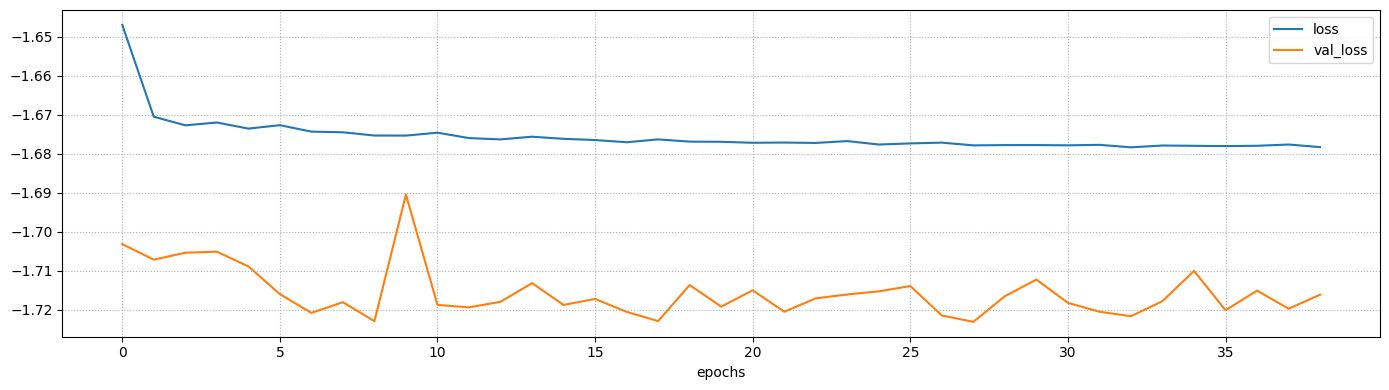

Final loss: -1.6783 (training), -1.7161 (validation)


In [36]:
X_train_map = inputs_train_map.values
X_val_map = inputs_val_map.values
X_test_map = inputs_test_map.values

print('Training the model with only MAP descriptor...')
map_model = build_nn_beta_model(input_shape=(X_train_map.shape[1],), hidden=hidden_layers,seed=seed) #[256,128]
history = util.train_nn_model(map_model, X_train_map, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_map, y_val))
util.plot_training_history(history, figsize=(14, 4))


### 3.2 Full-model

Training the model with all morphoclimatic descriptors...
Epoch 1/90
1823/1823 [==============================] - 7s 3ms/step - loss: -1.6366 - val_loss: -1.5847
Epoch 2/90
1823/1823 [==============================] - 5s 3ms/step - loss: -1.6728 - val_loss: -1.6753
Epoch 3/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6792 - val_loss: -1.6896
Epoch 4/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6815 - val_loss: -1.6577
Epoch 5/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6831 - val_loss: -1.6769
Epoch 6/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.6831 - val_loss: -1.7207
Epoch 7/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.6871 - val_loss: -1.7150
Epoch 8/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.6881 - val_loss: -1.6934
Epoch 9/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.6896 - val_loss: -1.7230
Epoch 

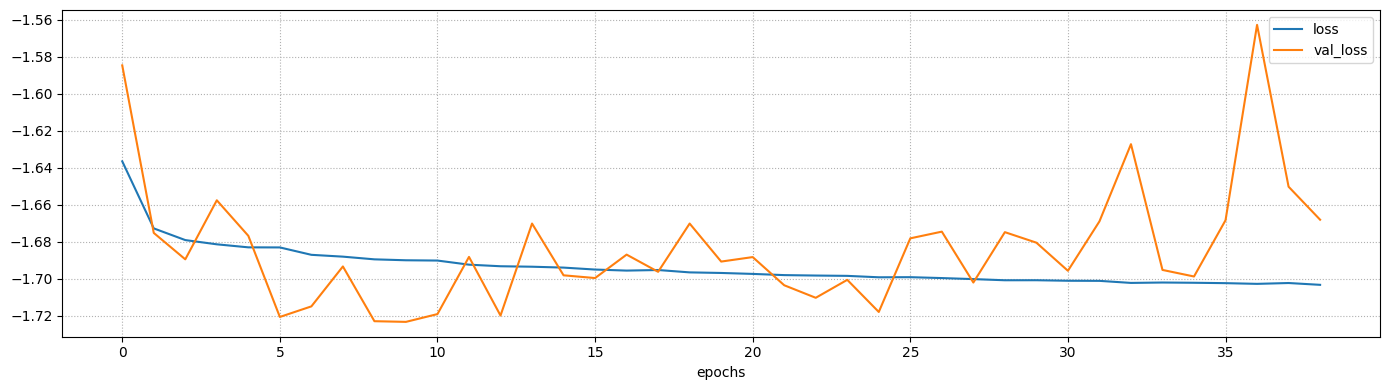

Final loss: -1.7033 (training), -1.6682 (validation)


In [84]:
X_train = inputs_train.values
X_val = inputs_val.values
X_test = inputs_test[inputs_test.columns[1:]].values

print('Training the model with all morphoclimatic descriptors...')
full_model = build_nn_beta_model(input_shape=(X_train.shape[1],), hidden=hidden_layers,seed=seed) #[256,128]
history = util.train_nn_model(full_model, X_train, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val, y_val))
util.plot_training_history(history, figsize=(14, 4))

### 3.3  PCA-model

Training the model with the PCA of the morphoclimatic descriptors...
Epoch 1/90
1823/1823 [==============================] - 5s 2ms/step - loss: -1.6252 - val_loss: -1.6022
Epoch 2/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6729 - val_loss: -1.7089
Epoch 3/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6775 - val_loss: -1.7105
Epoch 4/90
1823/1823 [==============================] - 3s 2ms/step - loss: -1.6788 - val_loss: -1.7056
Epoch 5/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.6798 - val_loss: -1.6831
Epoch 6/90
1823/1823 [==============================] - 4s 2ms/step - loss: -1.6788 - val_loss: -1.7172
Epoch 7/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.6820 - val_loss: -1.7156
Epoch 8/90
1823/1823 [==============================] - 3s 1ms/step - loss: -1.6826 - val_loss: -1.7042
Epoch 9/90
1823/1823 [==============================] - 2s 1ms/step - loss: -1.6834 - val_loss: -1.

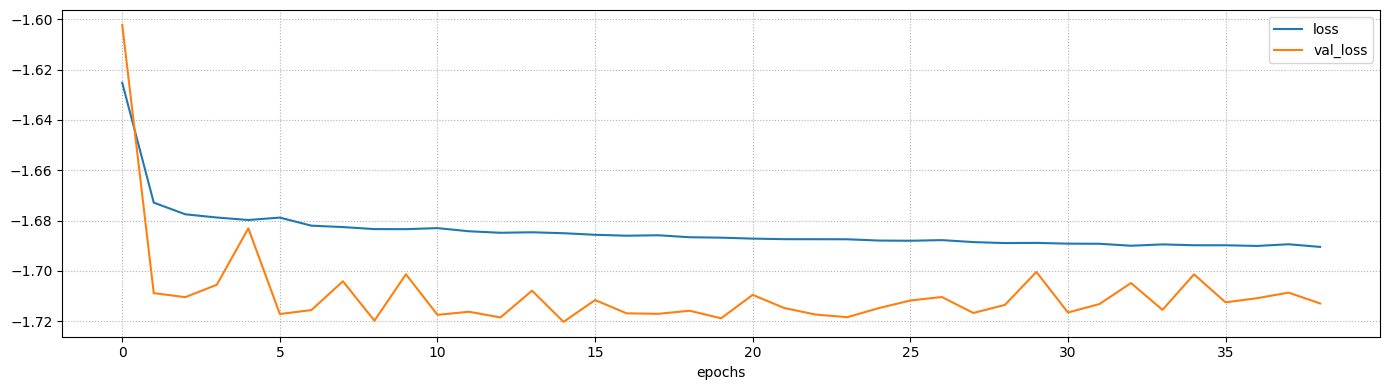

Final loss: -1.6905 (training), -1.7130 (validation)


In [38]:
X_train_pca = inputs_train_pca.values
X_val_pca = inputs_val_pca.values
X_test_pca = inputs_test_pca.values

print('Training the model with the PCA of the morphoclimatic descriptors...')
pca_model = build_nn_beta_model(input_shape=(X_train_pca.shape[1],), hidden=hidden_layers,seed=seed) #[256,128]
history = util.train_nn_model(pca_model, X_train_pca, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_pca, y_val))
util.plot_training_history(history, figsize=(14, 4))

## 4. Predictions

In [39]:
dist_train_map = map_model(X_train_map)
dist_val_map = map_model(X_val_map)
dist_test_map = map_model(X_test_map)

dist_train_full = full_model(X_train)
dist_val_full = full_model(X_val)
dist_test_full = full_model(X_test)

dist_train_pca = pca_model(X_train_pca)
dist_val_pca = pca_model(X_val_pca)
dist_test_pca = pca_model(X_test_pca)

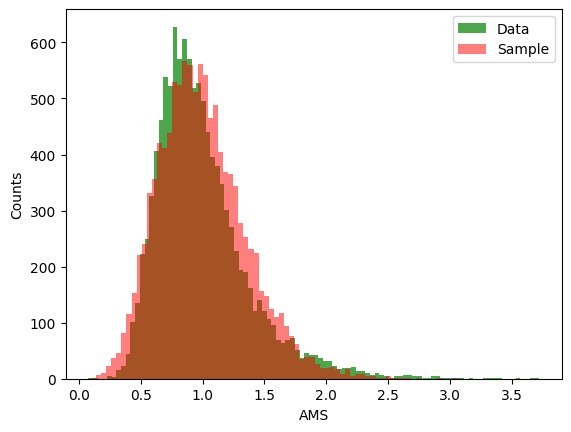

In [40]:
y_test_rescaled = util.inverse_scale_AMS(y_test, min_AMS, max_AMS)

y_pred = dist_test_full.sample(1).numpy().ravel()
y_pred_rescaled = util.inverse_scale_AMS(y_pred, min_AMS, max_AMS)

#y_pred = dist_train_map.sample(1).numpy().ravel()
#y_pred = dist_test_pca.sample(1).numpy().ravel()

util.plot_hist_samples(y_test_rescaled, y_pred_rescaled, 'red')

### 4.1 Confidence interval 

In [41]:
confidence = 0.99

Evaluation of MAP-model based on confidence intervals..


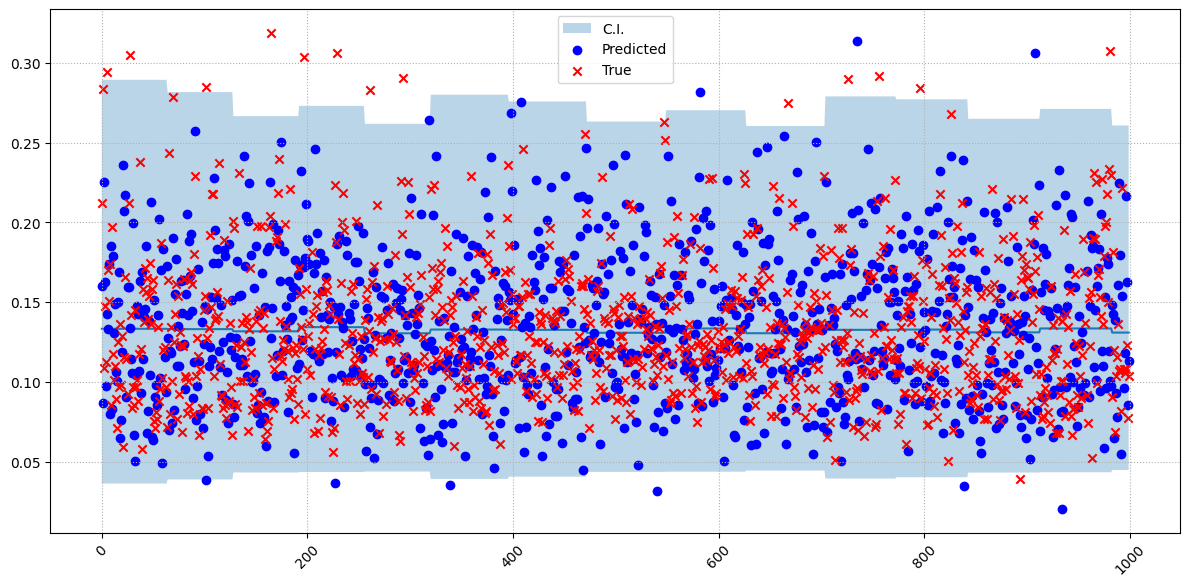

Percentage of values inside the 99% confidence interval: 97.78%


In [42]:
print('Evaluation of MAP-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_map, y_test, dist_test_map, confidence, distribution = 'beta', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of Full-model based on confidence intervals..


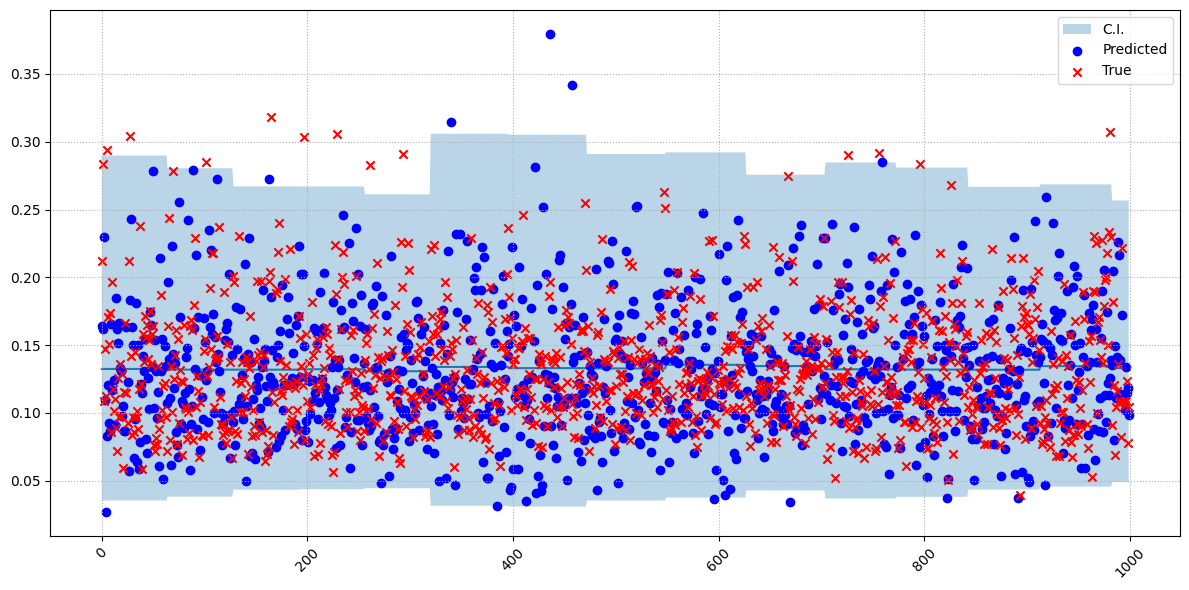

Percentage of values inside the 99% confidence interval: 97.86%


In [43]:
print('Evaluation of Full-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test, y_test, dist_test_full, confidence, distribution = 'beta', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of PCA-model based on confidence intervals..


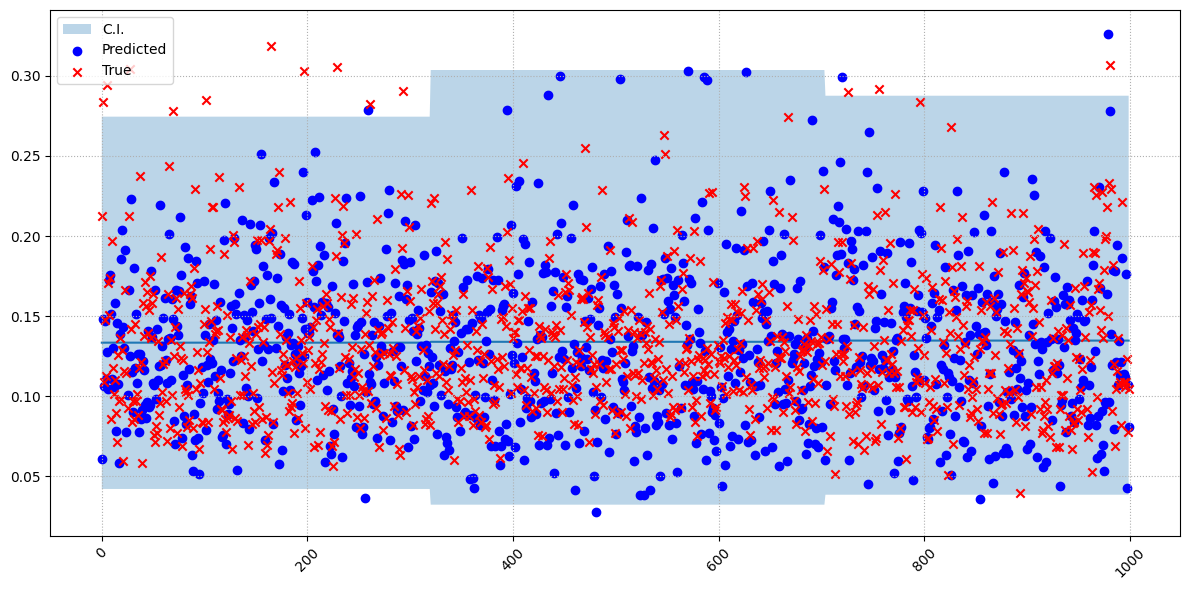

Percentage of values inside the 99% confidence interval: 97.91%


In [44]:
print('Evaluation of PCA-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_pca, y_test, dist_test_pca, confidence, distribution = 'beta', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

## 5. Parameters metrics

Metrics on parameters from MAP-model

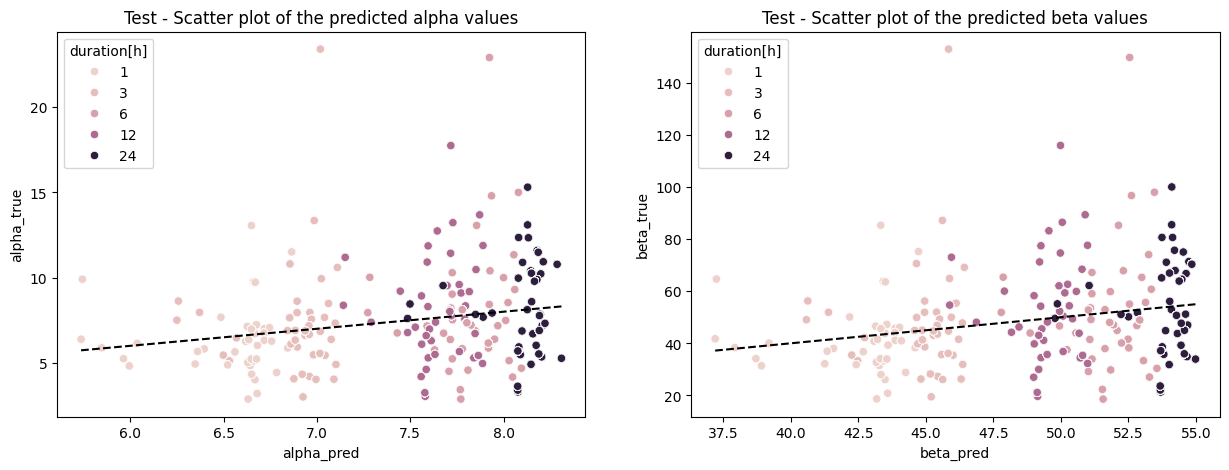

In [45]:
#Train
#_ = util.parameters_metrics(dist_train_map, parameters_train, distribution_name = 'beta', calculate_metrics = False, title='Train') 
#Test
metrics_alpha_map, metrics_beta_map = util.parameters_metrics(dist_test_map, parameters_test, distribution_name='beta', indexes=durations_indexes_test, remove_outliers = False)

In [46]:
print('===============ALPHA PARAMETER===============')
display(metrics_alpha_map)
print('===============BETA PARAMETER===============')
metrics_beta_map

===============ALPHA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.086953,-0.137597,-0.076666,-0.109494,-0.041044,-0.069896
mape,0.284798,0.258307,0.264521,0.318650,0.292795,0.289728
pcc,0.274958,0.059985,0.063227,0.167871,0.127163,0.062007


===============BETA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.093629,-0.137243,-0.078247,-0.127334,-0.033759,-0.091533
mape,0.288752,0.259686,0.266840,0.326524,0.293142,0.297591
pcc,0.268419,0.061317,0.065879,0.171158,0.122172,0.066217


Metrics on parameters from Full-model

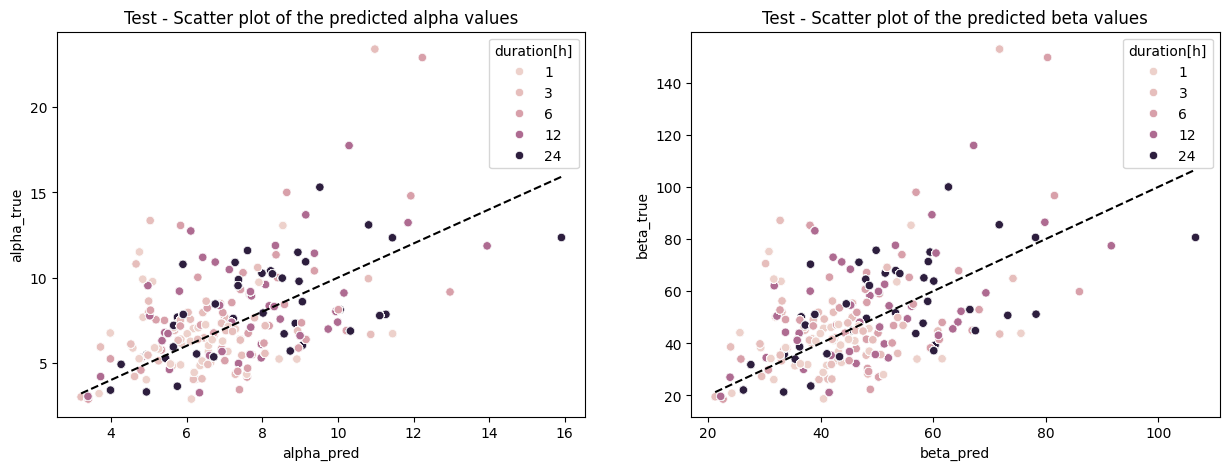

In [47]:
#train
#_ = util.parameters_metrics(dist_train_full, parameters_train, distribution_name = 'beta', calculate_metrics = False, title='Train')
#test
metrics_alpha_full, metrics_beta_full = util.parameters_metrics(dist_test_full, parameters_test, distribution_name='beta', indexes=durations_indexes_test, remove_outliers = False)

In [48]:
print('=============== FULL ALPHA PARAMETER===============')
display(metrics_alpha_full)
print('=============== FULL BETA PARAMETER===============')
metrics_beta_full

=============== FULL ALPHA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.027060,-0.089670,-0.012014,-0.035631,0.012044,-0.009954
mape,0.263019,0.278328,0.254583,0.289596,0.252715,0.239811
pcc,0.492082,0.143549,0.399362,0.525763,0.493911,0.527563


=============== FULL BETA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.037554,-0.103550,-0.023590,-0.048855,0.012873,-0.024584
mape,0.269662,0.287820,0.262308,0.292729,0.259165,0.246224
pcc,0.480423,0.135367,0.388786,0.521672,0.484867,0.510087


Metrics on parameters from PCA-model

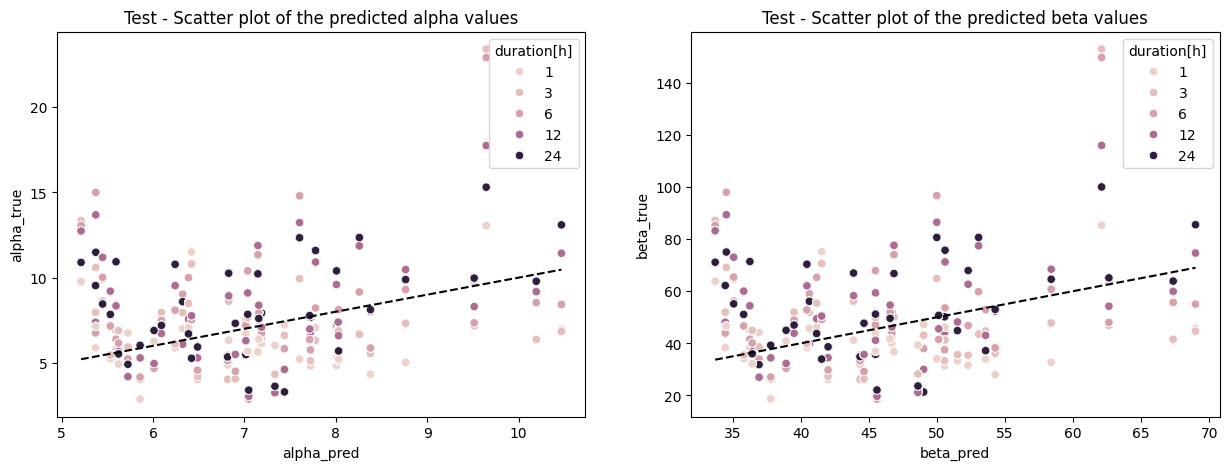

In [49]:
#_ = util.parameters_metrics(dist_train_pca, parameters_train, distribution_name = 'beta', calculate_metrics = False, title='Train')
metrics_alpha_pca, metrics_beta_pca = util.parameters_metrics(dist_test_pca, parameters_test, distribution_name='beta', indexes=durations_indexes_test, remove_outliers = False)

In [50]:
print('=============== PCA ALPHA PARAMETER===============')
display(metrics_alpha_pca)
print('=============== PCA BETA PARAMETER===============')
metrics_beta_pca

=============== PCA ALPHA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.050684,-0.237945,-0.115724,-0.005079,0.039952,0.065688
mape,0.304911,0.350528,0.336071,0.308775,0.270247,0.258823
pcc,0.200999,0.147431,0.111084,0.199569,0.281522,0.329587


=============== PCA BETA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.049127,-0.236079,-0.114497,-0.003699,0.041672,0.067278
mape,0.308005,0.353361,0.340016,0.311771,0.272241,0.262531
pcc,0.190587,0.135216,0.096640,0.188976,0.274081,0.318822


### 5.1 Comparison between two samples extracted from "true" and predicted distribution of the same place 

True alpha: 7.09, Predicted alpha: 7.42
True beta: 46.26, Predicted beta: 49.28
KS statistics:  0.025
p-value:  0.0038596010962783566


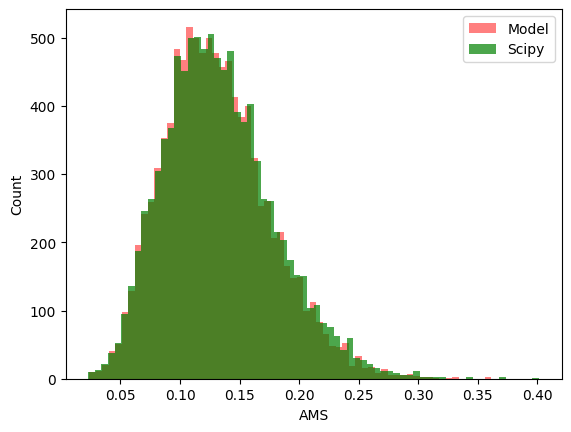

In [51]:
# Anzola dell'Emilia -> index 9252
util.compare_samples(dist_test_full, "beta", parameters_test, seed = seed, index=9252)

True alpha: 9.53, Predicted alpha: 8.59
True beta: 62.09, Predicted beta: 56.47
KS statistics:  0.0264
p-value:  0.0018791907538100322


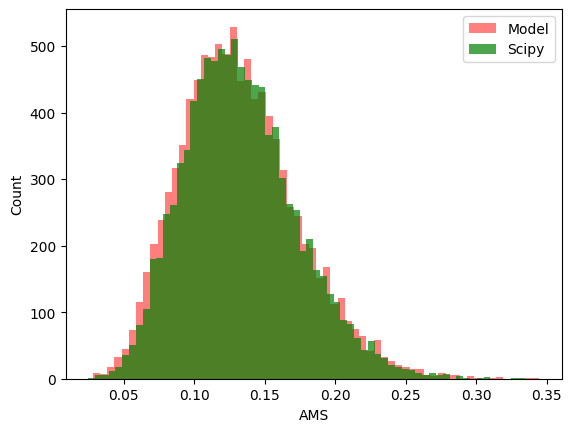

In [52]:
# Viganego -> index 10575
util.compare_samples(dist_test_full, "beta", parameters_test, seed = seed, index=10575)

#### neg log likelihood

In [53]:
alpha_pred, beta_pred, ams = test_df_std[['alpha', 'beta', 'AMS']].values.T
dist_pred = tfp.distributions.Beta(concentration0=beta_pred, concentration1=alpha_pred)
losses = -dist_pred.log_prob(ams)
loss_full_scipy = np.mean(losses)
print(loss_full_scipy)

-1.7008840949892565


In [54]:
# FULL
loss_full_pred = full_model.evaluate(X_test, y_test)
print(loss_full_pred)

353/353 [==============================] - 0s 787us/step - loss: -1.6715
-1.6714969873428345


In [55]:
# MAP
loss_map_pred = map_model.evaluate(X_test_map, y_test)
print(loss_map_pred)

353/353 [==============================] - 0s 920us/step - loss: -1.6658
-1.6657742261886597


In [56]:
# PCA
loss_pca_pred = pca_model.evaluate(X_test_pca, y_test)
print(loss_pca_pred)

  1/353 [..............................] - ETA: 8s - loss: -1.4360

353/353 [==============================] - 0s 1ms/step - loss: -1.6623
-1.6623482704162598


## 6. KS statistic

In [85]:
alpha_dict_pred, beta_dict_pred = util.parameters_to_dict(inputs_test, 'beta', full_model, DURATION)

In [86]:
ks_stat_beta, p_value_beta = util.KS_statistic(AMS_dict_test, alpha_dict_pred, beta_dict_pred, 'beta', DURATION)

In [87]:
# Create a dataframe containing the statistic for each ID and duration  
data_ks = []
for duration in DURATION:
    for id in ks_stat_beta[duration].keys():
        ks_statistic_pred_value = ks_stat_beta[duration][id]
        p_value_pred = p_value_beta[duration][id]
        data_ks.append((duration, id, ks_statistic_pred_value, p_value_pred))

df_ks_beta = pd.DataFrame(data_ks, columns=['duration', 'ID', 'ks_statistic_beta', 'p_value_beta'])
df_ks_beta


,duration,ID,ks_statistic_beta,p_value_beta
0,1,5005,0.073288,0.856855
1,1,5007,0.080356,0.998187
2,1,5015,0.124157,0.176437
3,1,5141,0.192769,0.294995
4,1,5143,0.098024,0.490695
...,...,...,...,...
495,24,16580,0.211694,0.941396
496,24,17011,0.081262,0.713509
497,24,17020,0.105830,0.501078
498,24,17024,0.127243,0.994109


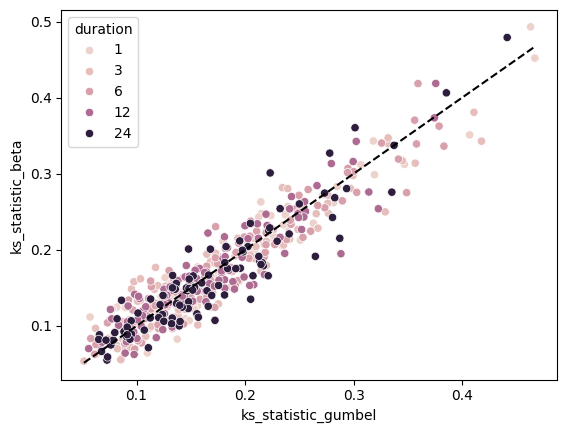

In [88]:
df_ks_gumbel = pd.read_pickle('results/ks_gumbel.pkl')
merged_df_ks = pd.merge(df_ks_beta, df_ks_gumbel)

sns.scatterplot(x='ks_statistic_gumbel', y='ks_statistic_beta', data=merged_df_ks, hue='duration')
x = np.linspace(merged_df_ks['ks_statistic_gumbel'].min(), merged_df_ks['ks_statistic_gumbel'].max(), 100)
plt.plot(x, x, color='black', linestyle='--')
plt.xlabel('ks_statistic_gumbel')
plt.ylabel('ks_statistic_beta')
plt.show()

In [89]:
#create a dictionary to store for each hour the list of ID for which the KS_beta is lower than KS_gumbel and p-value_beta is higher than p-value_gumbel

beta_better = {}
gumbel_better = {}
boh = {}

for duration in DURATION:
    beta_better[duration] = []
    gumbel_better[duration] = []
    boh[duration] = []
    for id in ks_stat_beta[duration].keys():
        ks_statistic_pred_value = ks_stat_beta[duration][id]
        p_value_pred = p_value_beta[duration][id]
        ks_statistic_gumbel = df_ks_gumbel[(df_ks_gumbel['duration'] == duration) & (df_ks_gumbel['ID'] == id)]['ks_statistic_gumbel'].values[0]
        p_value_gumbel = df_ks_gumbel[(df_ks_gumbel['duration'] == duration) & (df_ks_gumbel['ID'] == id)]['p_value_gumbel'].values[0]
        if ks_statistic_pred_value < ks_statistic_gumbel and p_value_pred > p_value_gumbel:
            beta_better[duration]+= [id]
        elif ks_statistic_pred_value > ks_statistic_gumbel and p_value_pred < p_value_gumbel:
            gumbel_better[duration]+= [id]
        else:
            boh[duration]+= [id]
    
print(beta_better)


{1: [5183, 5201, 5215, 5271, 5297, 5316, 5374, 8027, 8041, 8070, 8076, 8136, 8141, 9004, 9006, 9033, 9086, 9130, 9157, 9200, 9256, 9300, 9339, 10053, 10108, 10155, 12025, 12121, 12126, 12156, 12164, 12252, 12306, 12370, 12397, 12438, 12485, 12500, 16022, 16048, 16049, 16166, 16228, 16484, 16577, 17011, 17020, 17024, 17036], 3: [5005, 5143, 5183, 5215, 5294, 5297, 5302, 5316, 5374, 8013, 8027, 8037, 8041, 8076, 8136, 8141, 9004, 9006, 9033, 9086, 9157, 9203, 9256, 9296, 9312, 9339, 10079, 10155, 10218, 12156, 12164, 12252, 12281, 12306, 12398, 12438, 12485, 12500, 16022, 16026, 16038, 16048, 16049, 16058, 16078, 16097, 16102, 16126, 16166, 16211, 16221, 16228, 16484, 16568, 16577, 16580, 17011, 17020], 6: [5141, 5143, 5163, 5201, 5215, 5297, 5302, 5316, 5374, 8037, 8041, 8076, 8141, 9006, 9033, 9130, 9157, 9200, 9226, 9312, 10108, 12121, 12148, 12156, 12221, 12281, 12370, 12397, 12398, 12438, 12485, 12500, 16026, 16038, 16048, 16049, 16058, 16078, 16211, 16484, 16568, 17020, 17036], 12:

In [90]:
id_beta_better = []

for lista in beta_better.values():
    for elemento in lista:
        if elemento not in id_beta_better:
            id_beta_better.append(elemento)

print("Unique ID:", id_beta_better)

Unique ID: [5183, 5201, 5215, 5271, 5297, 5316, 5374, 8027, 8041, 8070, 8076, 8136, 8141, 9004, 9006, 9033, 9086, 9130, 9157, 9200, 9256, 9300, 9339, 10053, 10108, 10155, 12025, 12121, 12126, 12156, 12164, 12252, 12306, 12370, 12397, 12438, 12485, 12500, 16022, 16048, 16049, 16166, 16228, 16484, 16577, 17011, 17020, 17024, 17036, 5005, 5143, 5294, 5302, 8013, 8037, 9203, 9296, 9312, 10079, 10218, 12281, 12398, 16026, 16038, 16058, 16078, 16097, 16102, 16126, 16211, 16221, 16568, 16580, 5141, 5163, 9226, 12148, 12221, 5196, 8059, 9037, 9063, 8062, 8251, 9147, 10078, 12056]


In [91]:
id_gumbel_better = []

for lista in gumbel_better.values():
    for elemento in lista:
        if elemento not in id_gumbel_better:
            id_gumbel_better.append(elemento)

print("Unique ID:", id_gumbel_better)

Unique ID: [5005, 5007, 5015, 5141, 5143, 5151, 5156, 5163, 5196, 5247, 5294, 5302, 8013, 8037, 8059, 8062, 8091, 8113, 8251, 8264, 8270, 9037, 9063, 9088, 9147, 9203, 9226, 9296, 9312, 10078, 10079, 10218, 12056, 12127, 12134, 12148, 12221, 12280, 12281, 12398, 16026, 16038, 16058, 16078, 16097, 16102, 16126, 16211, 16221, 16568, 16580, 5201, 5271, 8070, 9130, 9200, 9300, 10053, 10108, 12025, 12121, 12126, 12370, 12397, 17024, 17036, 5183, 8027, 8136, 9004, 9086, 9256, 9339, 10155, 12164, 12252, 12306, 16022, 16166, 16228, 16577, 17011, 9033, 12500, 16048, 16484]


In [102]:
only_beta = list(set(id_beta_better) - set(id_gumbel_better))
only_gumbel = list(set(id_gumbel_better) - set(id_beta_better))
common_id = list(set(id_beta_better) & set(id_gumbel_better))


# Take X and Y for each ID in only_beta and only_gumbel from test_df

X_only_beta = test_df[test_df['ID'].isin(only_beta)].drop_duplicates('ID')['X']
Y_only_beta = test_df[test_df['ID'].isin(only_beta)].drop_duplicates('ID')['Y']
df_only_beta = pd.DataFrame({'ID': only_beta, 'X': X_only_beta, 'Y': Y_only_beta, 'dist': 'beta'})


X_only_gumbel = test_df[test_df['ID'].isin(only_gumbel)].drop_duplicates('ID')['X']
Y_only_gumbel = test_df[test_df['ID'].isin(only_gumbel)].drop_duplicates('ID')['Y']
df_only_gumbel = pd.DataFrame({'ID': only_gumbel, 'X': X_only_gumbel, 'Y': Y_only_gumbel, 'dist': 'gumbel'})

X_common = test_df[test_df['ID'].isin(common_id)].drop_duplicates('ID')['X']
Y_common = test_df[test_df['ID'].isin(common_id)].drop_duplicates('ID')['Y']
df_common = pd.DataFrame({'ID': common_id, 'X': X_common, 'Y': Y_common, 'dist': 'common'})
#concatenate the two dataframes

df_only = pd.concat([df_only_beta, df_only_gumbel, df_common])




In [103]:
df_only

,ID,X,Y,dist
6598,5316,729026.22,4954512.40,beta
8945,12485,679058.73,4916708.62,beta
9352,9157,635832.70,4900940.76,beta
10175,12156,580303.00,4918123.00,beta
11611,8041,475683.45,4932182.22,beta
...,...,...,...,...
44647,9203,692044.00,4881456.00,common
44665,12025,686610.00,4892840.00,common
44955,9339,658565.00,5084532.00,common
45266,10108,671071.00,5087380.00,common


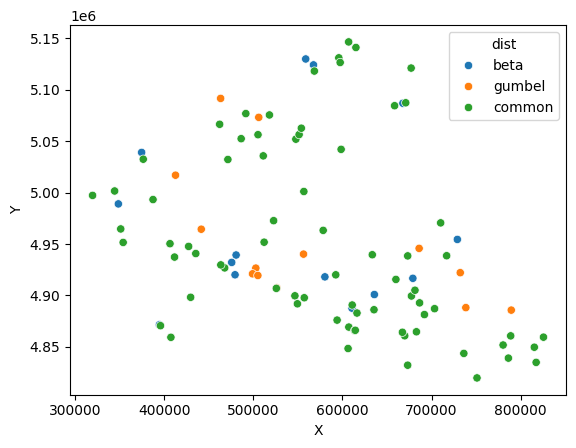

In [104]:
#make a scatter plot of 'X' and 'Y' from df_only, color by 'dist'

sns.scatterplot(x='X', y='Y', data=df_only, hue='dist')
plt.show()


In [105]:
print("Common ID:", len(common_id), " / ", len(merged_df_ks['ID'].unique()))

Common ID: 73  /  100


In [106]:
#how many ks_statistic_beta are lower than ks_statistic_gumbel

lower = merged_df_ks[merged_df_ks['ks_statistic_beta'] < merged_df_ks['ks_statistic_gumbel']]
print('Number of ks_statistic_beta lower than ks_statistic_gumbel: ', len(lower), " / ", len(merged_df_ks))


Number of ks_statistic_beta lower than ks_statistic_gumbel:  253  /  500


## 7. Error Analysis


### 7.1 Beta Distribution

In [100]:
metrics_name = ['biasr', 'mape', 'pcc']
models_name = ['map', 'full', 'pca']
models_metrics = [ metrics_alpha_map, metrics_alpha_full, metrics_alpha_pca]

In [101]:
alpha_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
alpha_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,-0.086953,-0.027060,-0.050684,0.284798,0.263019,0.304911,0.274958,0.492082,0.200999
1,-0.137597,-0.089670,-0.237945,0.258307,0.278328,0.350528,0.059985,0.143549,0.147431
3,-0.076666,-0.012014,-0.115724,0.264521,0.254583,0.336071,0.063227,0.399362,0.111084
6,-0.109494,-0.035631,-0.005079,0.318650,0.289596,0.308775,0.167871,0.525763,0.199569
12,-0.041044,0.012044,0.039952,0.292795,0.252715,0.270247,0.127163,0.493911,0.281522
24,-0.069896,-0.009954,0.065688,0.289728,0.239811,0.258823,0.062007,0.527563,0.329587


In [102]:
models_metrics = [ metrics_beta_map, metrics_beta_full, metrics_beta_pca]
beta_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
beta_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,-0.093629,-0.037554,-0.049127,0.288752,0.269662,0.308005,0.268419,0.480423,0.190587
1,-0.137243,-0.103550,-0.236079,0.259686,0.287820,0.353361,0.061317,0.135367,0.135216
3,-0.078247,-0.023590,-0.114497,0.266840,0.262308,0.340016,0.065879,0.388786,0.096640
6,-0.127334,-0.048855,-0.003699,0.326524,0.292729,0.311771,0.171158,0.521672,0.188976
12,-0.033759,0.012873,0.041672,0.293142,0.259165,0.272241,0.122172,0.484867,0.274081
24,-0.091533,-0.024584,0.067278,0.297591,0.246224,0.262531,0.066217,0.510087,0.318822


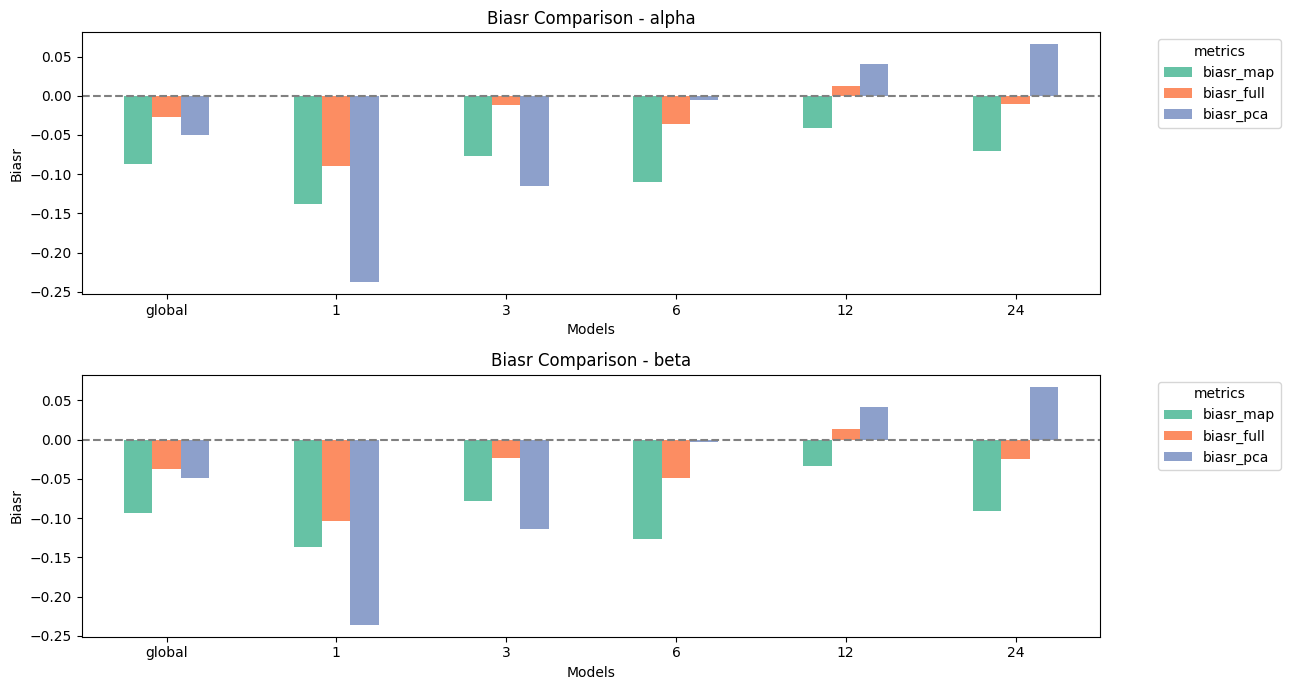

In [103]:
util.get_comparison_plot(alpha_metrics.iloc[:,0:3], beta_metrics.iloc[:,0:3], 'Biasr','beta', 'Set2')

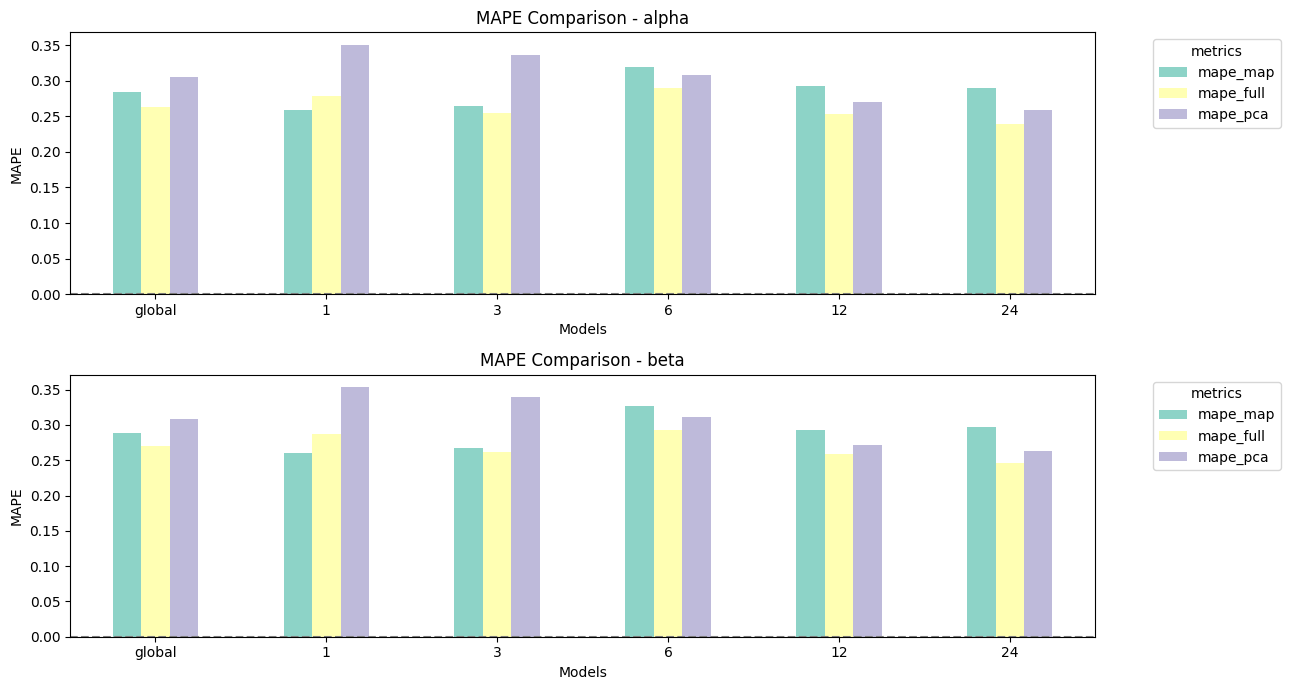

In [104]:
util.get_comparison_plot(alpha_metrics.iloc[:,3:6], beta_metrics.iloc[:,3:6], 'MAPE', 'beta','Set3')

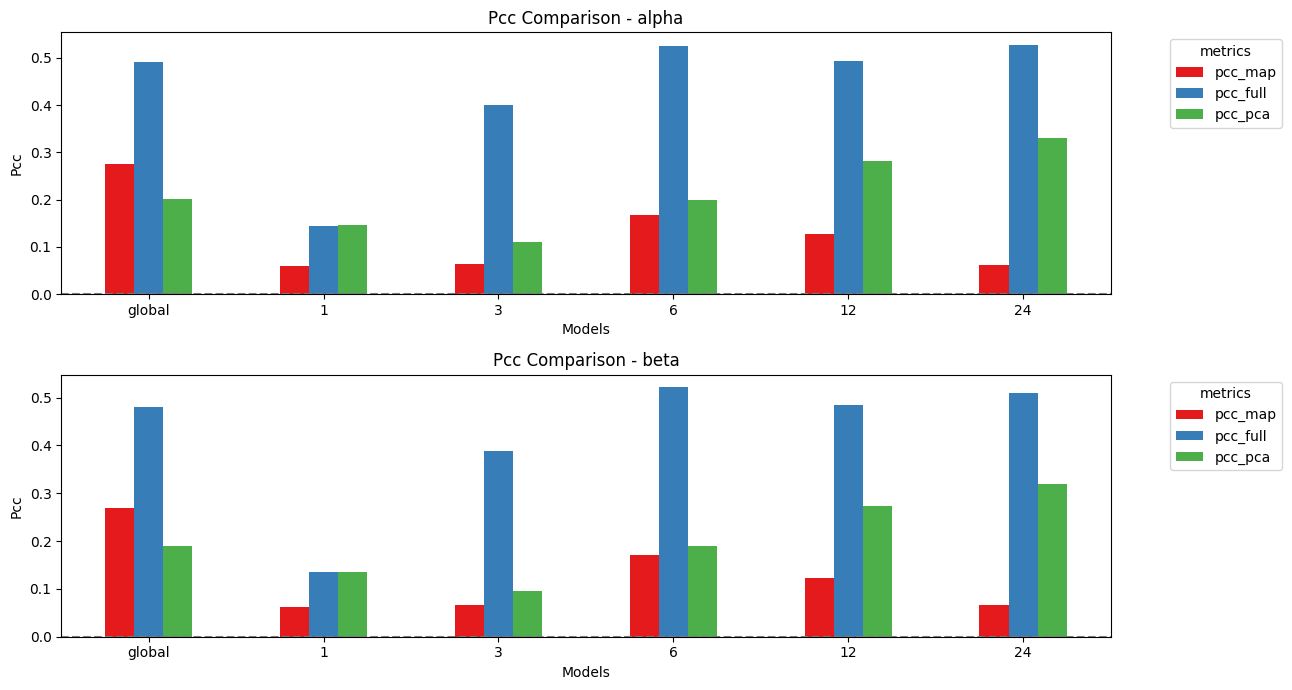

In [105]:
util.get_comparison_plot(alpha_metrics.iloc[:,6:9], beta_metrics.iloc[:,6:9], 'Pcc','beta', 'Set1')

The metrics used to evaluate the predictions on alpha and beta are: MAPE (Mean Absolute Percentage Error), Relative Bias, and PCC (Pearson Correlation Coefficient).
- MAPE: It measures the average percentage difference between the predicted or estimated values and the corresponding actual values, a lower value indicates better model accuracy. 
We chose this metric because it is less influenced by the order of magnitude.

- RBIAS:
If it is close to zero indicates that the model has a good tendency to predict values correctly, when it is positive the model tend to underestimate, while a negative relative bias indicates a tendency to overestimate the parameter.
 The Beta models tend to understimate the value of alpha and beta, in particular when considering the duration 1.

- PCC: It is a measure of the linear relationship between two variables.
It can range from -1 to 1. A value of 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no linear correlation.



Observing the graph, one of the first notable things is that the models show specular performance in predicting alpha and in predicting beta. Global metrics do not always reflect what is obtained considering the individual durations in which the use of one model rather than the other can lead to different results.


### 7.2 Gumbel Distribution

In [106]:
loc_metrics = pd.read_pickle('results/loc_metrics.pkl')
scale_metrics = pd.read_pickle('results/scale_metrics.pkl')

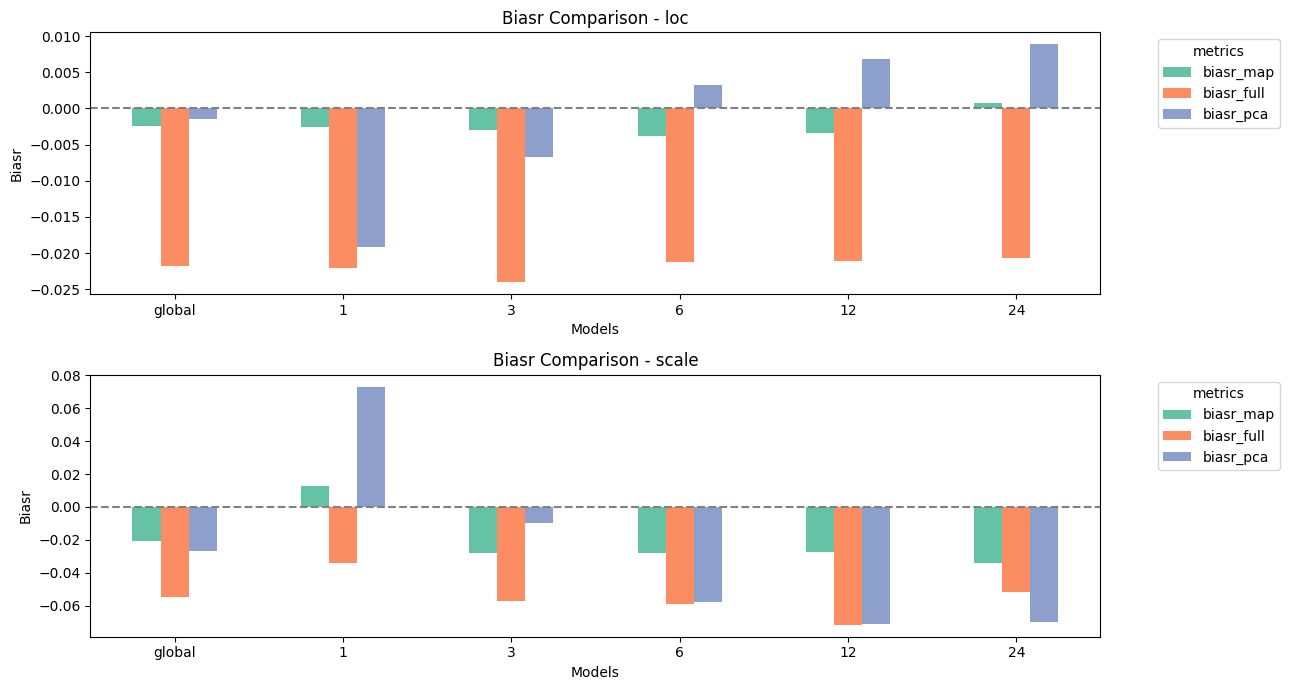

In [107]:
util.get_comparison_plot(loc_metrics.iloc[:,0:3], scale_metrics.iloc[:,0:3], 'Biasr','gumbel','Set2')

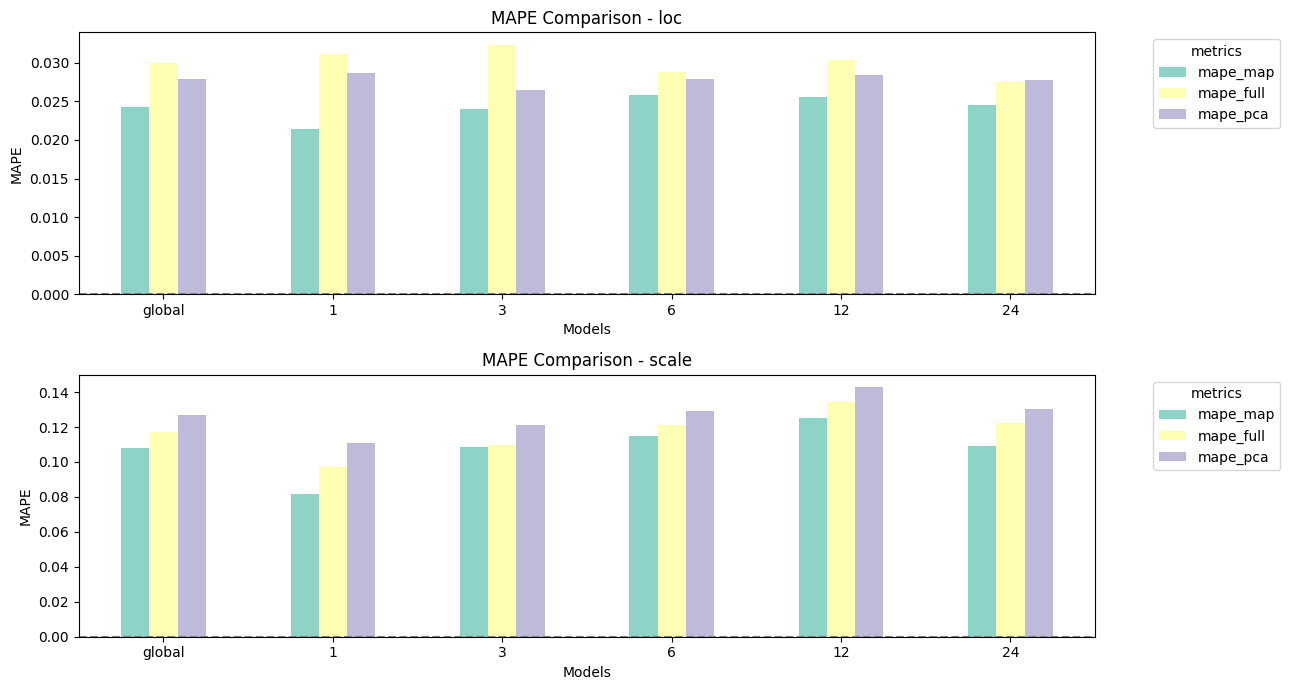

In [108]:
util.get_comparison_plot(loc_metrics.iloc[:,3:6], scale_metrics.iloc[:,3:6], 'MAPE', 'gumbel', 'Set3')

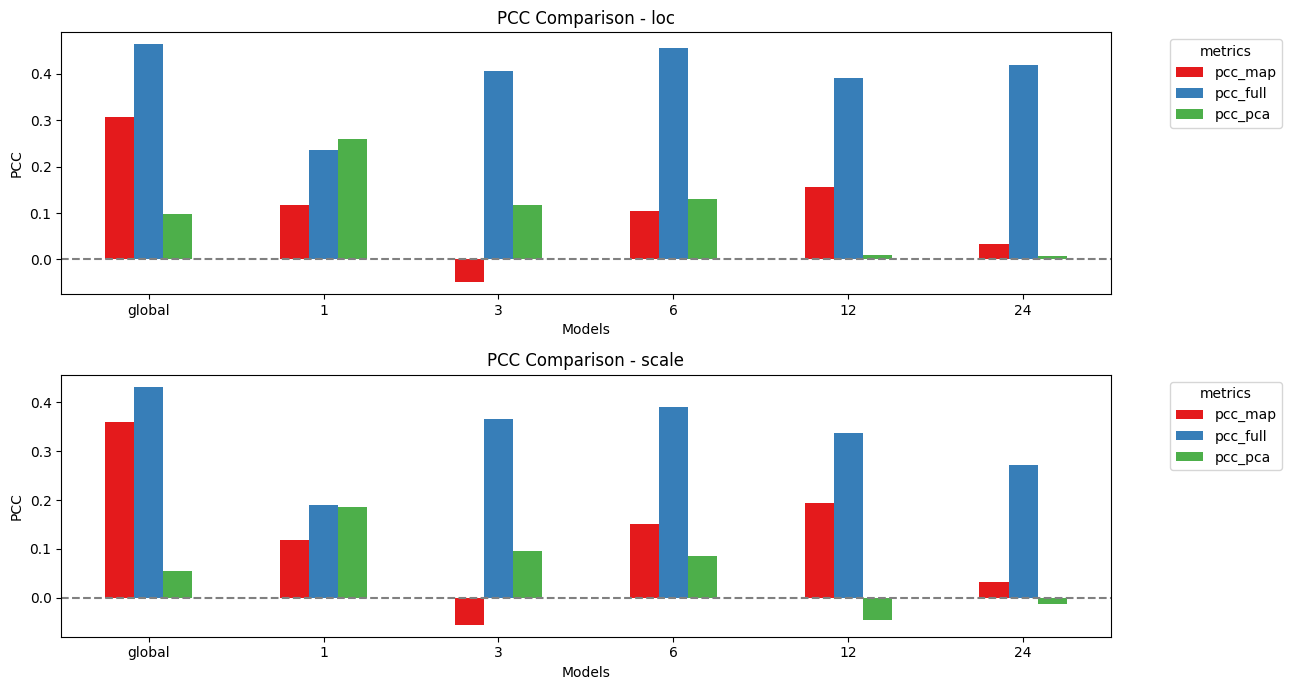

In [109]:
util.get_comparison_plot(loc_metrics.iloc[:,6:9], scale_metrics.iloc[:, 6:9], 'PCC', 'gumbel', 'Set1')

The results of the Gumbel are less symmetrical than those obtained with the Beta distribution. Observing the various metrics, the models therefore obtain different results for location and scale. 

The metrics suggest that:

- All three models are capable of estimating the parameters fairly accurately with minimal errors, often slightly overestimating them (RBias).
- The data does not exhibit a strong linear relationship (PCC)

### 7.3 Distributions Comparison

Since the results are all around the same order of magnitude, to compare the distributions we consider the 'global' values 

In [110]:
mape_comparison = pd.DataFrame()

In [111]:
mape_comparison["loc"] = loc_metrics.iloc[0,3:6].values
mape_comparison["scale"] = scale_metrics.iloc[0,3:6].values
mape_comparison["alpha"] = alpha_metrics.iloc[0,3:6].values
mape_comparison["beta"] = beta_metrics.iloc[0,3:6].values

In [112]:
mape_comparison.index = ['map', 'full', 'pca']
mape_comparison

,loc,scale,alpha,beta
map,0.024291,0.107936,0.284798,0.288752
full,0.030024,0.116903,0.263019,0.269662
pca,0.027878,0.126778,0.304911,0.308005


In [113]:
def plot_mape_comparison(df, title):
  fig, ax = plt.subplots(figsize=(18, 7))
  colors = sns.color_palette("Set2", 4)
  df.plot(kind='bar', ax=ax, rot=0, color=colors)

  plt.title('Scores Comparison'+" - " + title)
  plt.xlabel('Models')
  plt.ylabel('F1 Score')
  plt.legend(title='metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
  #ax.invert_yaxis()
  plt.tight_layout()

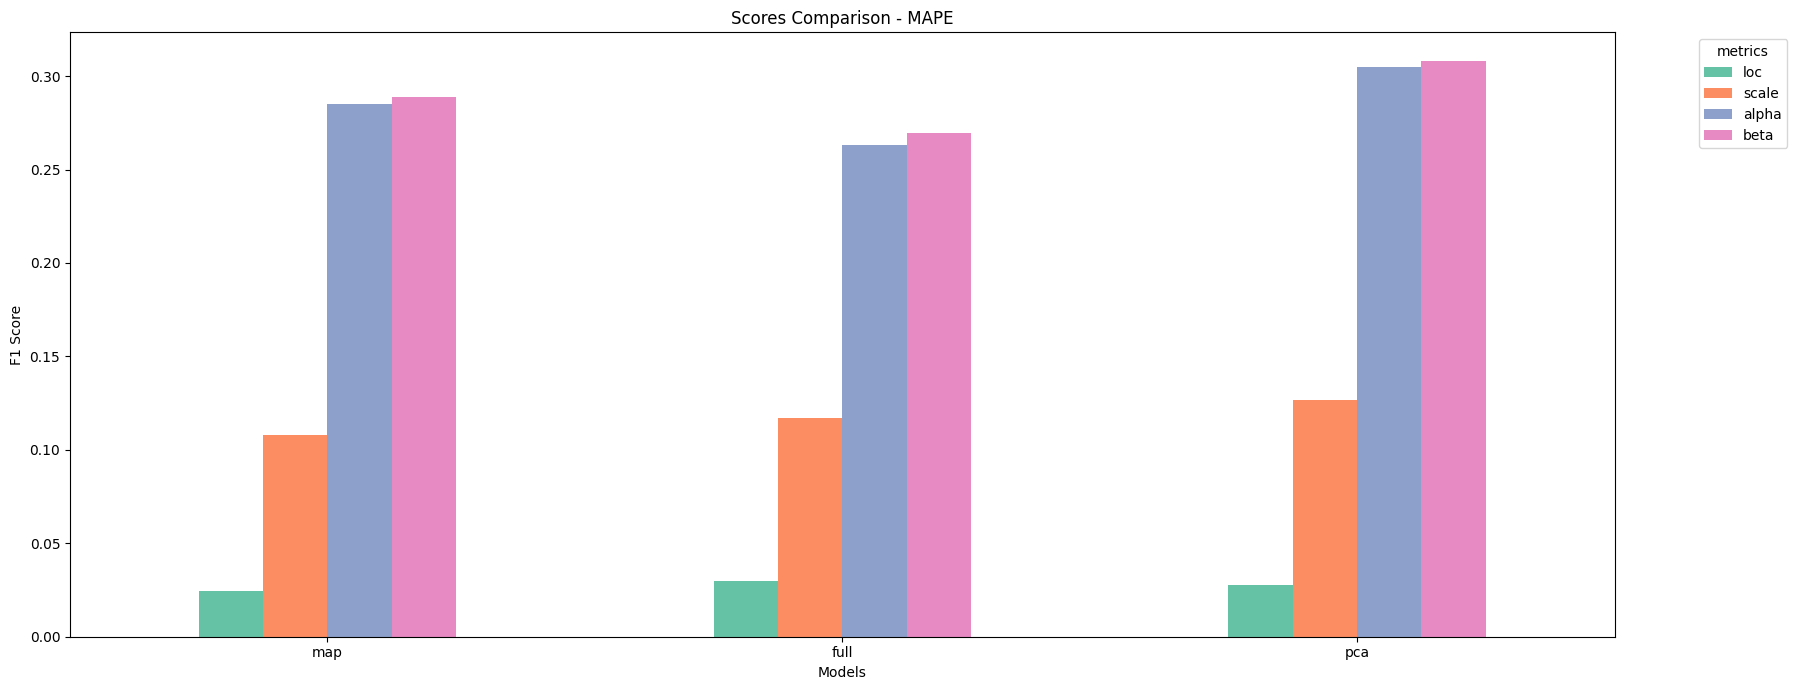

In [114]:
plot_mape_comparison(mape_comparison, 'MAPE')

For a more faithful comparison, we focused on the MAPE as it is a dimensionless and independent of the magnitude of the values.
Observing the graph, it is evident that the estimates made by the Gumbel distribution are much more accurate than those of the Beta distribution,
However, it should be considered that we are considering the estimation made by the scipy fitter as the 'true' value for the parameter, and  there is no certainty that they are actually accurate. Greater confidence would be achieved if all measurements had an higher number of observations.